In [212]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows=1000

In [195]:
Jan05= pd.read_csv('Jan05-19.txt')

In [196]:
Jan05.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [113]:
Jan05.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173


In [197]:
Jan05.columns=[col.strip() for col in Jan05.columns]
Jan05.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [198]:
Jan05['Entries']=Jan05.ENTRIES.diff()

In [199]:
Jan05['Exits']=Jan05.EXITS.diff()
Jan05=Jan05.drop(columns=['ENTRIES', 'EXITS','C/A','UNIT','SCP','LINENAME','DIVISION','DESC'])

In [200]:
Jan05[Jan05['Entries']<0].count()
#since we have 2% of the dirty data, we can drop the data

STATION    4087
DATE       4087
TIME       4087
Entries    4087
Exits      4087
dtype: int64

In [169]:
Jan05[Jan05['Exits']<0].count()

STATION    3809
DATE       3809
TIME       3809
Entries    3809
Exits      3809
dtype: int64

In [170]:
Jan05[(Jan05['Exits']<0) & (Jan05['Entries']<0)].count()

STATION    2638
DATE       2638
TIME       2638
Entries    2638
Exits      2638
dtype: int64

In [171]:
Jan05[(Jan05['Exits']<0) | (Jan05['Entries']<0)].count()

STATION    5258
DATE       5258
TIME       5258
Entries    5258
Exits      5258
dtype: int64

In [48]:
Jan05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201603 entries, 0 to 201602
Data columns (total 14 columns):
C/A            201603 non-null object
UNIT           201603 non-null object
SCP            201603 non-null object
STATION        201603 non-null object
LINENAME       201603 non-null object
DIVISION       201603 non-null object
DATE           201603 non-null datetime64[ns]
TIME           201603 non-null object
DESC           201603 non-null object
ENTRIES        201603 non-null int64
EXITS          201603 non-null int64
Entries        201602 non-null float64
Exits          201602 non-null float64
Day_Of_Week    201603 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 21.5+ MB


In [201]:
Jan05['Entries']=Jan05['Entries'].dropna() # this drops None, NaN, and NaT
Jan05

,STATION,DATE,TIME,Entries,Exits
0,59 ST,12/29/2018,03:00:00,NaN,NaN
1,59 ST,12/29/2018,07:00:00,12.0,16.0
2,59 ST,12/29/2018,11:00:00,65.0,102.0
3,59 ST,12/29/2018,15:00:00,241.0,63.0
4,59 ST,12/29/2018,19:00:00,361.0,72.0
5,59 ST,12/29/2018,23:00:00,220.0,46.0
6,59 ST,12/30/2018,03:00:00,44.0,12.0
7,59 ST,12/30/2018,07:00:00,7.0,11.0
8,59 ST,12/30/2018,11:00:00,42.0,46.0
9,59 ST,12/30/2018,15:00:00,149.0,69.0


In [208]:
Jan05 = Jan05.drop((Jan05[Jan05.Exits < 0] |Jan05[Jan05.Entries < 0] ).index)
#Jan05.drop(Jan05[Jan05.score < 50].index, inplace=True)
Jan05.head()

,STATION,DATE,TIME,Entries,Exits
0,59 ST,12/29/2018,03:00:00,NaN,NaN
1,59 ST,12/29/2018,07:00:00,12.0,16.0
2,59 ST,12/29/2018,11:00:00,65.0,102.0
3,59 ST,12/29/2018,15:00:00,241.0,63.0
4,59 ST,12/29/2018,19:00:00,361.0,72.0


In [210]:
Jan05[Jan05['Entries']<0].count()

STATION    0
DATE       0
TIME       0
Entries    0
Exits      0
dtype: int64

In [191]:
Jan05[Jan05['Exits']<0].count()

In [215]:
Jan05_Entry=Jan05.groupby(['DATE'])['Entries'].sum()
Jan05_Entry

DATE
01/01/2019    2.317568e+06
01/02/2019    5.219254e+06
01/03/2019    5.508161e+06
01/04/2019    5.455555e+06
12/29/2018    1.499943e+11
12/30/2018    9.872850e+09
12/31/2018    1.258799e+09
Name: Entries, dtype: float64

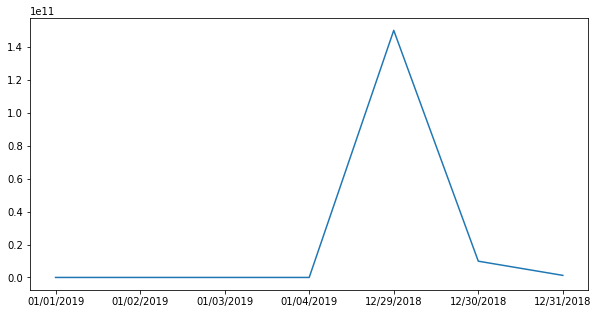

In [219]:
plt.figure(figsize = [10,5])
plt.plot(Jan05_Entry)
#need to add day of week

In [32]:
#What is the average number of entries per station per day?

In [33]:
Jan05['DATE']=pd.to_datetime(Jan05.DATE)

In [34]:
Jan05['Day_Of_Week']=Jan05.DATE.dt.weekday_name

In [40]:
Jan05.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Day_Of_Week
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,03:00:00,REGULAR,6889287,2335920,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,07:00:00,REGULAR,6889299,2335936,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,11:00:00,REGULAR,6889364,2336038,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,15:00:00,REGULAR,6889605,2336101,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,19:00:00,REGULAR,6889966,2336173,Saturday


In [61]:
Station_agg=Jan05.groupby(['DATE','STATION'])
Station_agg

In [3]:
import glob2

filenames = glob2.glob('*.txt') 

In [8]:
with open('final_file', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)